# Imports + Config

In [10]:
# Install dependencies
!pip -q install requests beautifulsoup4 lxml tqdm pandas yfinance

# Imports
import os
import re
import json
import time
from dataclasses import dataclass, asdict
from datetime import datetime, timedelta, timezone
from urllib.parse import urljoin, urlparse, urlunparse

import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import yfinance as yf

import matplotlib.pyplot as plt


# Config (paths + limits)
BASE_DIR = "."
COMPANIES_CSV = os.path.join(BASE_DIR, "companies.csv")

OUT_FDA_JSONL   = os.path.join(BASE_DIR, "data", "regulatory", "fda_docs.jsonl")
OUT_GDELT_JSONL = os.path.join(BASE_DIR, "data", "news", "gdelt_articles.jsonl")
OUT_YF_DIR      = os.path.join(BASE_DIR, "data", "financial", "yahoo")

os.makedirs(os.path.dirname(OUT_FDA_JSONL), exist_ok=True)
os.makedirs(os.path.dirname(OUT_GDELT_JSONL), exist_ok=True)
os.makedirs(OUT_YF_DIR, exist_ok=True)

# Run controls
FDA_MAX_PAGES = 200
FDA_MIN_RELEVANCE = 3
FDA_DELAY_S = 1.0

GDELT_DAYS_BACK = 14
GDELT_DELAY_S = 5.0
GDELT_MAXRECORDS = 50

YF_PERIOD = "5y"


# Load companies + build alias list

In [11]:
companies_df = pd.read_csv(COMPANIES_CSV)

def build_aliases(df: pd.DataFrame) -> list[str]:
    aliases = []
    for _, row in df.iterrows():
        aliases.append(str(row.get("company_name","")).strip())
        aliases.append(str(row.get("ticker","")).strip())
        extra = str(row.get("aliases","")).strip()
        if extra:
            aliases.extend([a.strip() for a in extra.split(";") if a.strip()])
    seen, out = set(), []
    for a in aliases:
        if a and a not in seen:
            out.append(a)
            seen.add(a)
    return out

COMPANY_ALIASES = build_aliases(companies_df)
len(COMPANY_ALIASES), COMPANY_ALIASES[:10]


(58,
 ['Pfizer Inc.',
  'PFE',
  'Pfizer',
  'Johnson & Johnson',
  'JNJ',
  'J&J',
  'Johnson and Johnson',
  'Merck & Co., Inc.',
  'MRK',
  'Merck'])

# Helper functions

In [12]:
def now_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

def normalize_ws(text: str) -> str:
    return re.sub(r"\s+", " ", (text or "")).strip()

def normalize_url(url: str) -> str:
    # Drop fragments, normalize trailing slashes, normalize netloc casing.
    p = urlparse(url)
    p = p._replace(fragment="", netloc=p.netloc.lower())
    path = p.path or "/"
    if path != "/" and path.endswith("/"):
        path = path[:-1]
    p = p._replace(path=path)
    return urlunparse(p)

def safe_makedirs_for_file(path: str):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)


# Crawler 1: FDA focused crawler (JSONL)

In [13]:
FDA_ALLOWED_DOMAINS = {"www.fda.gov", "fda.gov"}

FDA_SEEDS = [
    "https://www.fda.gov/safety/recalls-market-withdrawals-safety-alerts",
    "https://www.fda.gov/drugs/drug-safety-and-availability",
    "https://www.fda.gov/news-events/fda-newsroom/press-announcements",]

FDA_KEYWORDS = [
    "recall", "warning letter", "safety", "adverse", "labeling", "approval", "enforcement",
    "market withdrawal", "alert", "communication", "inspection",]

def fda_is_allowed(url: str) -> bool:
    try:
        host = urlparse(url).netloc.lower()
        return host in FDA_ALLOWED_DOMAINS or host.endswith(".fda.gov")
    except Exception:
        return False

def fda_relevance_score(text: str, url: str = "") -> int:
    t = (text or "").lower()
    u = (url or "").lower()
    score = 0
    for kw in FDA_KEYWORDS:
        if kw in t:
            score += 2
        if kw.replace(" ", "-") in u or kw.replace(" ", "") in u:
            score += 1
    return score

def fda_extract_main_text(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    for tag in soup(["script", "style", "noscript", "header", "footer", "nav", "aside"]):
        tag.decompose()
    main = soup.find("main") or soup.find("article")
    text = main.get_text(separator=" ", strip=True) if main else soup.get_text(separator=" ", strip=True)
    return normalize_ws(text)

def fda_extract_title(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    if soup.title and soup.title.text:
        return normalize_ws(soup.title.text)
    h1 = soup.find("h1")
    return normalize_ws(h1.get_text(strip=True)) if h1 else ""

def fda_extract_links(html: str, base_url: str) -> list[str]:
    soup = BeautifulSoup(html, "lxml")
    links = []
    for a in soup.find_all("a", href=True):
        href = a["href"].strip()
        if href.startswith("#") or href.lower().startswith("javascript:"):
            continue
        abs_url = normalize_url(urljoin(base_url, href))
        if fda_is_allowed(abs_url):
            links.append(abs_url)
    return links

def lightweight_mentions(text: str, company_aliases: list[str]) -> list[str]:
    t = text or ""
    hits = []
    for alias in company_aliases:
        a = alias.strip()
        if not a:
            continue
        if a.isupper() and 1 < len(a) <= 5:
            pattern = rf"\b{re.escape(a)}\b"
            if re.search(pattern, t):  # case-sensitive
                hits.append(a)
        else:
            pattern = rf"\b{re.escape(a)}\b"
            if re.search(pattern, t, flags=re.IGNORECASE):
                hits.append(a)

    # de-dupe preserving order
    seen, out = set(), []
    for h in hits:
        if h not in seen:
            out.append(h)
            seen.add(h)
    return out

def fda_fetch(session: requests.Session, url: str, timeout: int = 20) -> tuple[str|None, int|None, str]:
    headers = {
        "User-Agent": "MSDS459-KG-Crawler/1.0 (educational)",
        "Accept-Language": "en-US,en;q=0.9",
    }
    try:
        r = session.get(url, headers=headers, timeout=timeout)
        status = r.status_code
        final_url = normalize_url(r.url)
        if status != 200:
            return None, status, final_url
        ctype = (r.headers.get("Content-Type") or "").lower()
        if "text/html" not in ctype:
            return None, status, final_url
        return r.text, status, final_url
    except requests.RequestException:
        return None, None, normalize_url(url)

@dataclass
class FDADoc:
    source: str
    url: str
    fetched_at: str
    http_status: int|None
    title: str
    text: str
    relevance: int
    mentions: list[str]

def run_fda_crawler(
    out_jsonl: str,
    seeds: list[str] = FDA_SEEDS,
    max_pages: int = 200,
    min_relevance: int = 3,
    delay_s: float = 1.0,
    company_aliases: list[str] = None
) -> None:
    safe_makedirs_for_file(out_jsonl)
    company_aliases = company_aliases or []

    seen = set()
    frontier = [normalize_url(s) for s in seeds]
    frontier_set = set(frontier)

    wrote = 0

    with requests.Session() as session, open(out_jsonl, "w", encoding="utf-8") as f:
        for _ in tqdm(range(max_pages), desc="FDA Crawl"):
            if not frontier:
                break

            frontier.sort(key=lambda u: fda_relevance_score("", u), reverse=True)
            url = frontier.pop(0)
            frontier_set.discard(url)

            if url in seen:
                continue
            seen.add(url)

            html, status, final_url = fda_fetch(session, url)
            time.sleep(delay_s)

            if not html:
                continue

            title = fda_extract_title(html)
            text = fda_extract_main_text(html)
            rel = fda_relevance_score(text, final_url)

            if rel >= min_relevance and len(text) > 400:
                mentions = lightweight_mentions(text, company_aliases)
                rec = FDADoc(
                    source="FDA",
                    url=final_url,
                    fetched_at=now_iso(),
                    http_status=status,
                    title=title,
                    text=text,
                    relevance=rel,
                    mentions=mentions,
                )
                f.write(json.dumps(asdict(rec), ensure_ascii=False) + "\n")
                wrote += 1

            for link in fda_extract_links(html, final_url):
                if link not in seen and link not in frontier_set and len(frontier) < max_pages * 10:
                    frontier.append(link)
                    frontier_set.add(link)

    print(f"FDA done. Wrote {wrote} docs to {out_jsonl}. Visited {len(seen)} pages.")


# Crawler 2: GDELT collector (JSONL)

In [14]:
def gdelt_fetch(query, start_dt, end_dt, maxrecords=50):
    url = "https://api.gdeltproject.org/api/v2/doc/doc"
    params = {
        "query": query,
        "mode": "ArtList",
        "format": "json",
        "maxrecords": maxrecords,
        "startdatetime": start_dt.strftime("%Y%m%d%H%M%S"),
        "enddatetime": end_dt.strftime("%Y%m%d%H%M%S"),
        "sort": "datedesc",
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def run_gdelt_collector(
    companies_df: pd.DataFrame,
    out_jsonl: str,
    days_back: int = 14,
    delay_s: float = 5.0,
    maxrecords: int = 50
):
    safe_makedirs_for_file(out_jsonl)

    end_dt = datetime.now(timezone.utc)
    start_dt = end_dt - timedelta(days=days_back)

    wrote = 0
    with open(out_jsonl, "w", encoding="utf-8") as f:
        for _, row in tqdm(companies_df.iterrows(), total=len(companies_df), desc="GDELT"):
            name = row["company_name"]
            ticker = row["ticker"]

            q = f'("{name}" OR "{ticker}") AND (health OR FDA OR drug OR device OR recall OR approval)'

            data = gdelt_fetch(q, start_dt, end_dt, maxrecords=maxrecords)
            for a in data.get("articles", []):
                rec = {
                    "source": "GDELT",
                    "company": name,
                    "ticker": ticker,
                    "query": q,
                    "fetched_at": now_iso(),
                    "url": a.get("url"),
                    "title": a.get("title"),
                    "seendate": a.get("seendate"),
                    "domain": a.get("domain"),
                    "language": a.get("language"),
                    "sourceCountry": a.get("sourceCountry"),
                    "tone": a.get("tone"),
                }
                f.write(json.dumps(rec, ensure_ascii=False) + "\n")
                wrote += 1

            time.sleep(delay_s)

    print(f"GDELT done. Wrote {wrote} records to {out_jsonl}.")


# Crawler 3: Yahoo Finance time series (CSV)

In [15]:
def run_yahoo_finance_downloader(
    companies_df: pd.DataFrame,
    out_dir: str,
    period: str = "5y"
) -> pd.DataFrame:
    os.makedirs(out_dir, exist_ok=True)

    summary = []
    for tkr in tqdm(companies_df["ticker"].tolist(), desc="Yahoo Finance"):
        df = yf.download(tkr, period=period, interval="1d", progress=False)
        df = df.reset_index()

        out_path = os.path.join(out_dir, f"{tkr}.csv")
        df.to_csv(out_path, index=False)

        summary.append({
            "ticker": tkr,
            "rows": len(df),
            "start": str(df["Date"].min()) if len(df) else None,
            "end": str(df["Date"].max()) if len(df) else None
        })

    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(os.path.join(out_dir, "summary.csv"), index=False)
    print(f"Yahoo Finance done. Saved CSVs to {out_dir}")
    return summary_df


# Run Crawlers

In [17]:
# FDA
run_fda_crawler(
    out_jsonl=OUT_FDA_JSONL,
    max_pages=FDA_MAX_PAGES,
    min_relevance=FDA_MIN_RELEVANCE,
    delay_s=FDA_DELAY_S,
    company_aliases=COMPANY_ALIASES)


# Yahoo Finance
yf_summary = run_yahoo_finance_downloader(
    companies_df=companies_df,
    out_dir=OUT_YF_DIR,
    period=YF_PERIOD)
yf_summary.head()


#GDELT
run_gdelt_collector(
    companies_df=companies_df,
    out_jsonl=OUT_GDELT_JSONL,
    days_back=GDELT_DAYS_BACK,
    delay_s=GDELT_DELAY_S,
    maxrecords=GDELT_MAXRECORDS)




FDA Crawl: 100%|██████████████████████████████| 200/200 [08:34<00:00,  2.57s/it]


FDA done. Wrote 196 docs to ./data/regulatory/fda_docs.jsonl. Visited 200 pages.


Yahoo Finance: 100%|████████████████████████████| 18/18 [00:26<00:00,  1.45s/it]


Yahoo Finance done. Saved CSVs to ./data/financial/yahoo


GDELT:   0%|                                             | 0/18 [00:00<?, ?it/s]


HTTPError: 429 Client Error: Too Many Requests for url: https://api.gdeltproject.org/api/v2/doc/doc?query=%28%22Pfizer+Inc.%22+OR+%22PFE%22%29+AND+%28health+OR+FDA+OR+drug+OR+device+OR+recall+OR+approval%29&mode=ArtList&format=json&maxrecords=50&startdatetime=20260201195914&enddatetime=20260215195914&sort=datedesc

# Data Check (FDA)

In [18]:
def read_jsonl(path: str) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

fda_df = read_jsonl(OUT_FDA_JSONL)
fda_df[["title","url","relevance","mentions"]].head(10)


,title,url,relevance,mentions
0,"Recalls, Market Withdrawals, & Safety Alerts |...",https://www.fda.gov/safety/recalls-market-with...,12,[]
1,Enforcement Reports | FDA,https://www.fda.gov/safety/recalls-market-with...,15,[]
2,"Trividia Health, Inc. Initiates Labeling Corre...",https://www.fda.gov/safety/recalls-market-with...,13,[]
3,Recall Resources | FDA,https://www.fda.gov/safety/recalls-market-with...,12,[]
4,Industry Guidance For Recalls | FDA,https://www.fda.gov/safety/recalls-market-with...,10,[]
5,Major Product Recalls | FDA,https://www.fda.gov/safety/recalls-market-with...,8,[]
6,Additional Information about Recalls | FDA,https://www.fda.gov/safety/recalls-market-with...,14,[]
7,"Updated Company Announcement to August 28, 202...",https://www.fda.gov/safety/recalls-market-with...,14,[]
8,"Ambrosia Brands, LLC Recalls Rosabella Moringa...",https://www.fda.gov/safety/recalls-market-with...,6,[]
9,IF Copack LLC dba Initiative Foods Recalls “Ti...,https://www.fda.gov/safety/recalls-market-with...,10,[]


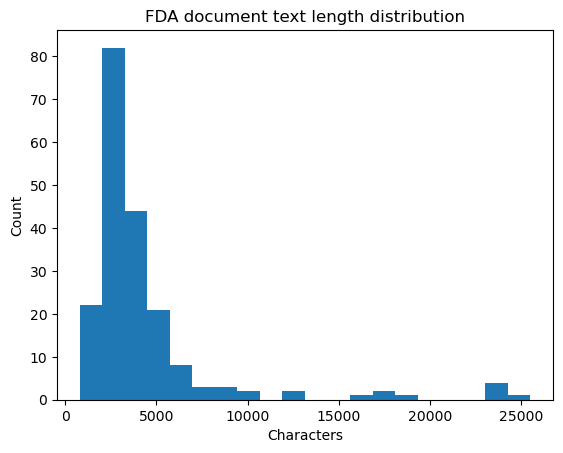

In [19]:
fda_df["text_len"] = fda_df["text"].astype(str).str.len()

plt.figure()
plt.hist(fda_df["text_len"], bins=20)
plt.title("FDA document text length distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

In [20]:
from collections import Counter

all_mentions = []
for m in fda_df["mentions"].dropna():
    all_mentions.extend(m)

counts = Counter(all_mentions)
top = counts.most_common(15)

top_df = pd.DataFrame(top, columns=["mention","count"])
top_df


,mention,count
0,BMS,9
1,J&J,3
2,Medtronic,3
3,Boston Scientific Corporation,3
4,Boston Scientific,3
5,Merck,1
6,Merck & Co,1
7,MDT,1


# Data Check (Yahoo Finance)

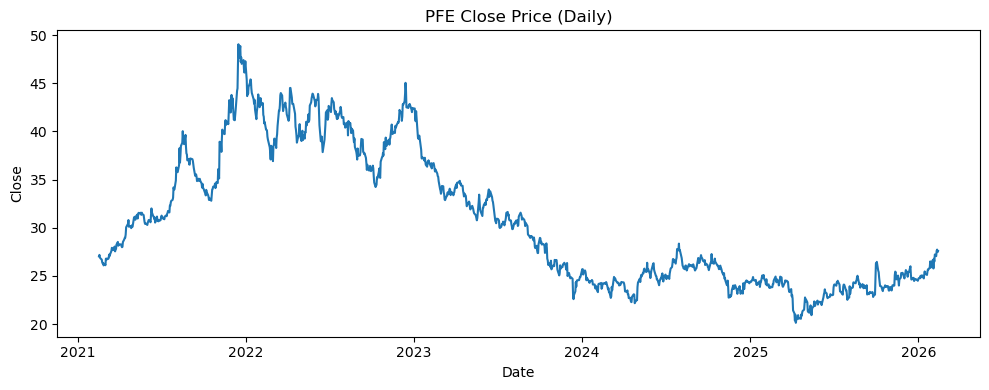

In [25]:
ticker = "PFE"
pfe_path = os.path.join(OUT_YF_DIR, f"{ticker}.csv")
pfe = pd.read_csv(pfe_path)

pfe["Date"] = pd.to_datetime(pfe["Date"], errors="coerce")
pfe["Close"] = pd.to_numeric(pfe["Close"], errors="coerce")

pfe = pfe.dropna(subset=["Date", "Close"]).sort_values("Date")

plt.figure(figsize=(10,4))
plt.plot(pfe["Date"], pfe["Close"])
plt.title(f"{example_ticker} Close Price (Daily)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.show()
